## INTRODUCTION

In this tutorial we will build a model that predicts next character in a sentence, based on the previous few characters.
We will use a special kind Recurrent Neural Networks(RNN( for doing this.
This tutorial will also expose you to the basics of RNN and Long Short Term Memory(LSTM) networks.

## Recurrent Neural Networks
Traditional neural networks, lack the capability of using about previous knowledge to predict later events, actions, or words. This issue can be addressed by using RNN models. In addition to providing a way to examine the current input, RNN models provide a way to examine the input that was provided in the previous step. They have loops in them, that allows information to persist.
We can think of an RNN as copies of same network, each of which passses a message to a successor.

To understand it better we can unroll the RNN loop and see how it works.

Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
<img src="images/rnn.png">

Reference:
https://www.tensorflow.org/tutorials/recurrent

One of the features of RNN is their capabilty to connect previous information to the present task. In cases where the gap between the context and prediction is relatively small, RNN can learn based on past information. 
But in cases that need more context from the text history, it becomes difficult for RNN the learn and connect information.

## Long Short Term Memory networks
These are special kind of RNN that are capable of learning from the text context when the gap between context and prediction is more. These networks are specially designed to avoid the long-term dependency issue.

Unlike standard RNN in which the repeating module only has a sigle layer, LSTM has a different structure for the repeating module.
There are four layers of the neural network that interact in a special way. The key to LSTM model is a memory cell that is composed of:
- Input Gate
- Forget Gate
- Output gates
- A neuron that connects to itself

Reference:
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Source: http://deeplearning.net/
<img src="images/lstm.png">

## Tutorial Content
- <a href='#setup'>Setup the Environment</a>
- <a href='#install'>Install libraries</a>
- <a href="#load">Load Data</a>
- <a href='#preprocess'>Preprocess Data</a>
- <a href='#fnl'>Features and Labels</a>
- <a href='#build'>Build the Model</a>
- <a href='#train'>Train the Model</a>
- <a href='#save'>Save and Load the Model</a>
- <a href='#evaluate'>Evaluate loss and accuracy</a>
- <a href='#test'>Test the model</a>

<a id='setup'></a>
## Setup the Environment
We will develop a simple LSTM network.
Let us begin by importing all the required modules and seed our random number generator.

- We will use TensorFlow and Keras Sequential Model for our purpose.
- We also need to import different layers from Keras.
- We will use RMSprop optimizer for our RNN.
- Keras models are trained on Numpy arrays of input data and labels.

<a id='install'></a>
## Install libraries
### TensorFlow with Anaconda
#### Windows
- conda create -n tensorflow pip python=3.5
- activate tensorflow
- To install the CPU-only version of TensorFlow, enter the following command:

  pip install --ignore-installed --upgrade tensorflow 
  
- To install the GPU version of TensorFlow, enter the following command (on a single line):

  pip install --ignore-installed --upgrade tensorflow-gpu 

#### macOs
- conda create -n tensorflow pip python=2.7 # or python=3.3, etc.
- source activate tensorflow
- pip install --ignore-installed --upgrade TF_PYTHON_URL

Source: https://www.tensorflow.org/install/

In [12]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

np.random.seed(42)
tf.set_random_seed(42)

<a id='load'></a>
## Load data
After installing all the required libraries we are ready to load our dataset.

We will be using the lowercase text version from EBook of Alice’s Adventures in Wonderland, by Lewis Carroll as our training corpus.

Download the text file from https://www.gutenberg.org/files/11/11-0.txt.
Save it as data/alice.txt in the root directory.

For simplicity we are using all lowercase text. Load the file from the path and save it in a variable 'text'.

In [13]:
filepath = 'data/alice.txt'
text = open(filepath).read().lower()

We can see the size of our dataset.

In [14]:
print('dataset length:', len(text))

dataset length: 144524


<a id='preprocess'></a>
## Preprocess Data

After loading the file, we will now prepare data for modelling by the network. Before we can do that we must convert the characters to integers.
We will also create a reverse mapping which will be used later to convert integers back to characters for us to understand the predictions.

To do this we will:
1. Create a set of all of the distinct characters in the book
2. Ctore the unique characters in the corpus and create two dictionaries:
a.	Character as key and index as value
b.	Index as key and character as value, then creating a map of each character to a unique integer.




In [15]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Now we can summarize our dataset.

In [16]:
print('Total characters:', len(text))
print(f'Number of unique chars: {len(chars)}')

Total characters: 144524
Number of unique chars: 47


We will now define the training data(input_seq). There are many ways in which we can split the text to expose it for training to the network.
We will also store the next character(output_seq) for every sequence, this is the character we need to predict.

There are many ways we could do this, but for our case, we will split the corpus into subsequences of 50 characters, and space them by 3 characters.

In [17]:
seq_len = 50
step_size = 3

input_seq = []
output_seq = []

for i in range(0, len(text) - seq_len, step_size):
    input_seq.append(text[i: i + seq_len])
    output_seq.append(text[i + seq_len])
print(f'num training examples: {len(input_seq)}')
print(len(input_seq))

num training examples: 48158
48158


<a id='fnl'></a>
## Features and Labels
Now we can generate the features and labels for our data. We will create one-hot encoded vectors using the dictionary (char_indices), the sequence of characters and the characters that need to be predicted we created earlier.

Each training pattern is comprised of 50 time steps of one character (X) followed by one character output (y). The sliding window for these sentences is 3 character at a time, that allows each charactre to learn from 100 previous characters.

We will now transform our training data so it is understandable by Keras.

- Transform list to samples, time steps and features, expected by LSTM network.
- Rescale integers to the range 0-1 
- Convert the output pattern ti one-hot vectors. This is to fit a probabilistic model that assigns probabilities to each of the unique character in the vocab.

We convert each y value into a sparse vector of zeros with a 1 in the column for the letter (integer) that the pattern represents. This vector is of length 47.
For example, when “n” (integer value 31) is one hot encoded it looks as follows:

In [18]:
X = np.zeros((len(input_seq), seq_len, len(chars)), dtype=np.bool)
y = np.zeros((len(input_seq), len(chars)), dtype=np.bool)
for i, sentence in enumerate(input_seq):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[output_seq[i]]] = 1  

Let us see how the pieces look like:
    - Training sequence looks
    - The character prediction for the sentence
    - One-hot vector for the prediction
    - Dimensions of the X and y
For the given data set:

We have 48158 training examples, each sequence has length of 50 with 47 unique chars.

In [19]:
print(input_seq[100])
print(output_seq[100])
print(X[0][0])
print(X.shape)
print(y.shape)

nothing to do: once or twice she had peeped into t
h
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
(48158, 50, 47)
(48158, 47)


<a id='build'></a>
## Build the Model
We will now define our model.
The model we will train will have a single hidden LSTM layer with 256 neurons(memory units) that will accept input of shape (50, 57) (the length of a sequence, the number of unique characters in our dataset). Later, we will add a fully connected layer for our output which is a Dense layer using softmax activation function to out a probability prediction for each unique chraater.

In [20]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

<a id='train'></a>
## Train the Model
We will use RMSProp optimizer for speed, since the problem lies in classifying single character with 47 classes and also a need to optimize cross entropy.
We will fit our model for 20 epochs and a batch size of 128 patterns. The data split is 95-5
for training and validation.

In [ ]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], ver)
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

<a id='save'></a>
## Save and Load the Model
Since there is no test datasett and we are modeling the entire training dataset to learn the probability of each character in a sequence, the network is slow to train and we do not want to lose or retrain the model once trained.
So we will save the trained model and load it to make sure it works.

In [29]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

<a id='evaluate'></a>
## Evaluate loss and accuracy
Usinf matplotlib, we can visualize how the accuracy and loss changed over training epochs:

In [30]:
%matplotlib inline

sns.set(style='darkgrid',palette='Dark2', font_scale=1)

rcParams['figure.figsize'] = 10, 5

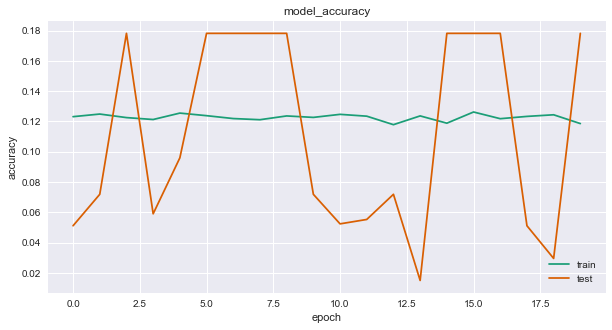

In [31]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right');

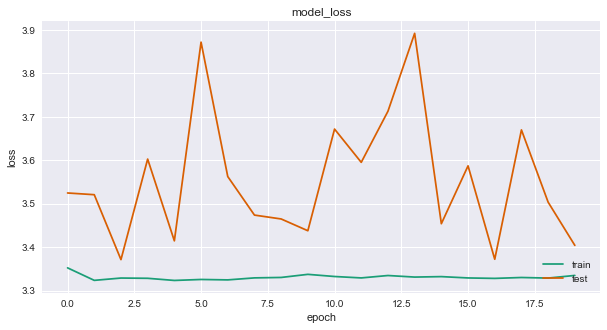

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right');

<a id='test'></a>
## Test the model
We can now generate text and predict some word completions using our model.

We will create some helper functions to prepare our input data and samples.

#### Helper functions

Input function: Will return a tensor with shape (1, 50, 47), initialized with zeros. For each character in the passed text, 1 is placed. (All text must be lower case and the sequencd must be 50 char long.)

Sample function: Returns the n next most probable characters.

In [32]:
def prepare_input_data(text):
    m = np.zeros((1, seq_len, len(chars)))
    for t, char in enumerate(text):
        m[0, t, char_indices[char]] = 1.
    return m

def sample(predicts, first_n=3):
    predicts = np.asarray(predicts).astype('float64')
    predicts = np.log(predicts)
    exp_predicts = np.exp(predicts)
    predicts = exp_predicts / np.sum(exp_predicts)
    
    return heapq.nlargest(first_n, range(len(predicts)), predicts.take)

#### Prediction functions

predict_nextChar: This function prepare the input repeatedly, and asks the model for predictions and sampling for them. The function predicts next character until it finds the space charracter.

predict_completions: This function allows us to predict multiple characters for multiple inputs.

In [39]:
def predict_nextChar(text):
    orig_text = text
    completion_char = ''
    while True:
        m = prepare_input_data(text)
        predicts = model.predict(m)[0]
        next_index = sample(predicts, first_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion_char += next_char
        
        if len(orig_text + completion_char) + 2 > len(orig_text) and next_char == ' ':
            return completion_char
        
def predict_all(text, n=3):
    x = prepare_input_data(text)
    preds = model.predict(x)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_nextChar(text[1:] + indices_char[idx]) for idx in next_indices]   

We will use sequences of 50 characters as seed for our inout. These sentences are from the book itself. (Alice’s Adventures in Wonderland)

References:

https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [47]:
sentences = [
    "There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself",
    "As if it wasn’t trouble enough hatching the eggs,’ said the Pigeon;‘but I must be on the look-out for serpents night and day!",
    "You promised to tell me your history, you know,’ said Alice,",
    "Alice did not at all like the tone of this remark, and thought it would be as well to introduce some other subject of conversation.",
    "This answer so confused poor Alice, that she let the Dormouse go on for some time without interrupting it"
]
for q in sentences:
    seq = q[:50].lower()
    print(seq)
    print(predict_all(seq, 5))
    print()

there was nothing so very remarkable in that; nor 
['  ', 'i ', 'n ', 't ', 'g ']

as if it wasn’t trouble enough hatching the eggs,’


/Users/sachisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


['  ', 'i ', 'n ', 't ', 'g ']

you promised to tell me your history, you know,’ s
['  ', 'i ', 'n ', 't ', 'g ']

alice did not at all like the tone of this remark,
['  ', 'i ', 'n ', 't ', 'g ']

this answer so confused poor alice, that she let t
['  ', 'i ', 'n ', 't ', 'g ']

